In [2]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt

sigma = 0.08
T = np.array([0.1,0.25,0.5,0.75,1,1.5,2,3,4,5,7,10])
R_star = np.array([0.0334, 0.0352, 0.0375, 0.0392, 0.0405, 0.0422,
                   0.0433, 0.0445, 0.0451, 0.0455, 0.0459, 0.0462])

def objective(theta, sigma, T, R_star):
    r0, a, b = theta

    # --- YOU must compute model-implied spot rates here ---
    # placeholder:
    R_model = np.zeros_like(T)  # <-- replace with CIR-implied spot rates

    sse = np.sum((R_model - R_star)**2)
    return sse

x0 = np.array([0.025, 1.5, 0.07])

res = minimize(
    objective,
    x0,
    args=(sigma, T, R_star),
    method="Nelder-Mead",
    options={"xatol": 1e-8, "disp": True},
)

print("Parameter estimates (r0, a, b):", res.x)
print("SSE:", res.fun)


Optimization terminated successfully.
         Current function value: 0.020919
         Iterations: 24
         Function evaluations: 119
Parameter estimates (r0, a, b): [0.025 1.5   0.07 ]
SSE: 0.020919229999999997


In [6]:
def simulate_CIR_path_rng(r0, a, b, sigma, T, M, rng):
    dt = T / M
    sqrt_dt = np.sqrt(dt)

    r = np.zeros(M + 1)
    r[0] = r0

    for m in range(M):
        Z = rng.standard_normal()
        r_next = (
            r[m]
            + a * (b - r[m]) * dt
            + sigma * np.sqrt(max(r[m], 0.0)) * sqrt_dt * Z
        )
        r[m+1] = max(r_next, 0.0)

    return r


def price_short_rate_derivative_CIR_MC(
    r0, a, b, sigma,
    T, M, N,
    seed=None,
    return_samples=False
):
    rng = np.random.default_rng(seed)
    dt = T / M
    X = np.zeros(N)

    for n in range(N):
        r = simulate_CIR_path_rng(r0, a, b, sigma, T, M, rng)

        discount = np.exp(-dt * np.sum(r[:-1]))   # approx exp(-∫ r dt)
        payoff = np.max(r)                        # your chosen payoff

        X[n] = discount * payoff

    price = np.mean(X)
    if return_samples:
        return price, X
    return price

In [10]:
r0, a, b = 0.032, 2, 0.047
sigma = 0.08
M_deriv, T_deriv = 1000, 2
N_deriv = 10000

price, X = price_short_rate_derivative_CIR_MC(
    r0, a, b, sigma,
    T_deriv, M_deriv, N_deriv,
    seed=42,
    return_samples=True
)

print(f"Fair value of the derivative: {price}")

N_conv = np.array([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000])
for n in N_conv:
    pi_hat = np.mean(X[:n])
    print(n, pi_hat)


Fair value of the derivative: 0.054398917454112156
1000 0.05456284398006289
2000 0.054534777958811106
3000 0.05459055050721433
4000 0.054575522998550875
5000 0.054570008049453375
6000 0.054528626498836504
7000 0.05449751145042249
8000 0.054445377268812094
9000 0.054419553369770765
10000 0.054398917454112156


DV01 for the swap with maturity: 7 when bumping entire spot rate curve is 6.052713548579964 bps
DV01 for the swap with maturity: 7 when bumping spot rate at T: 1 by 1.0 bps is -0.002568769511119712 bps


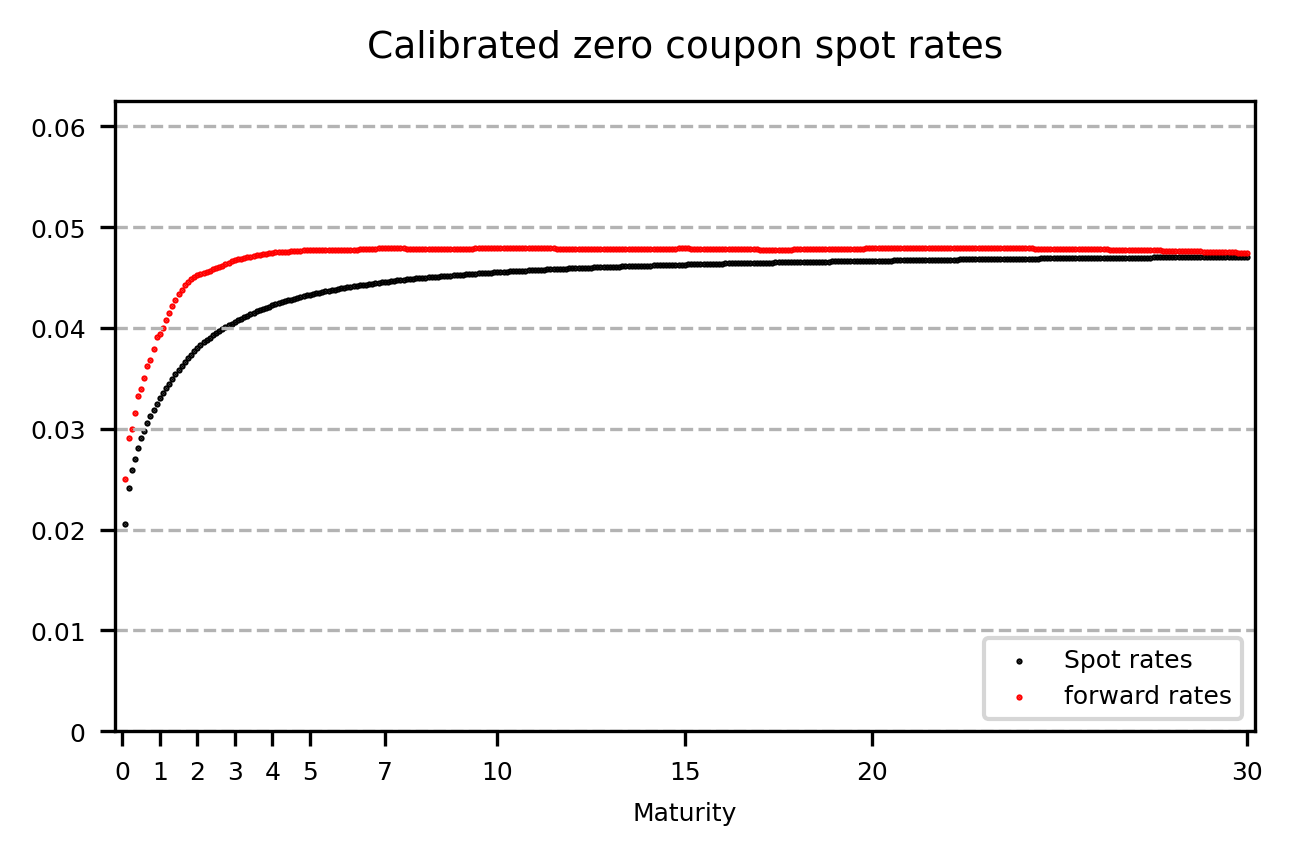

In [18]:
# Problem 2
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.02927}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03161},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03295},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03418},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.03531},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.03635},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.03731},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.03819},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.03900},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.03975}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.03824, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04083, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04242, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04346, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04468, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.04561, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.04633, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.04667, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.04700, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

interpolation_options = {"method": "hermite", "degree": 3, "transition": "smooth"}
# interpolation_options = {"method": "linear"}
T_fit, R_fit = fid.zcb_curve_fit(data, interpolation_options=interpolation_options)

mesh = 1/12
T_max = 30
T_inter = np.arange(0, T_max + mesh, mesh)   # dit “resolution” styrer du her

p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(
    T_inter, T_fit, R_fit,
    interpolation_options=interpolation_options
)
# DV01 when bumping entire spot rate curve
idx_swap,size_bump=14,0.0001
T_N=data[idx_swap]["maturity"]
R_inter_bump,p_inter_bump=fid.spot_rate_bump(T_inter,size_bump,T_inter,R_inter,p_inter)
S_swap_bump=fid.accrual_factor_from_zcb_prices(0,0,T_N,"semiannual",T_inter,p_inter_bump)
R_swap_bump=fid.swap_rate_from_zcb_prices(0,0,T_N,"semiannual",T_inter,p_inter_bump)[0]
DV01=(R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for the swap with maturity: {T_N} when bumping entire spot rate curve is {10000*DV01} bps")


# DVO1 when bumping one point
idx_swap,T_bump,size_bump=14,1,0.0001
T_N=data[idx_swap]["maturity"]
R_inter_bump,p_inter_bump=fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
S_swap_bump=fid.accrual_factor_from_zcb_prices(0,0,T_N,"semiannual",T_inter,p_inter_bump)
R_swap_bump=fid.swap_rate_from_zcb_prices(0,0,T_N,"semiannual",T_inter,p_inter_bump)[0]
DV01=(R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for the swap with maturity: {T_N} when bumping spot rate at T: {T_bump} by {10000*size_bump} bps is {10000*DV01} bps")


fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[1:], R_inter[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[1:], f_inter[1:], s = 1, color = 'red', marker = ".",label="forward rates")
# p3 = ax.scatter(T_swap, R_swap, s = 1, color = 'green', marker = ".",label="par swap rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()



6M forward LIBOR: [   nan 0.0385 0.0477 0.0527 0.0555 0.0566 0.0568 0.0569 0.0569]
S_swap: 3.580845089117633, R_swap: 0.05307796270952918
price_cap: 0.037746892584287706, R_cap: 0.010541336373081986, premium twice a year: 0.005270668186540993
price_swaption: 0.02683993510220535, R_swaption: 0.007495419219271242, premium twice a year: 0.003747709609635621
2Y4Y forward par swap rate: 0.053115709145571254
iv_market
[0.31555267 0.27571732 0.2417579  0.21251243 0.18717002 0.16594365
 0.15032339 0.1418881  0.14075951 0.14458939 0.15091799 0.15822536
 0.16563506]


TypeError: sigma_sabr() got an unexpected keyword argument 'type'

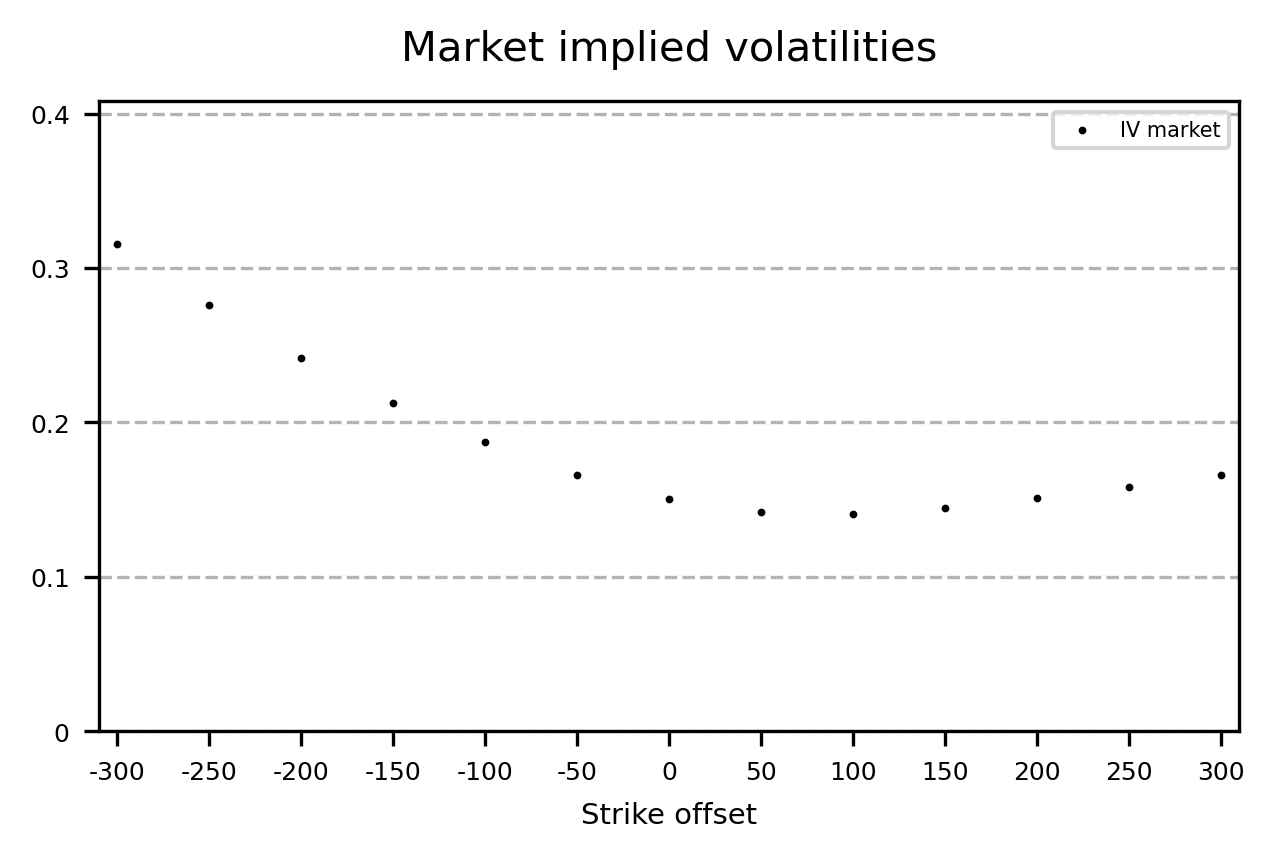

In [30]:
# Problem 3
M = 9
alpha = 0.5
R = 0.05
T = np.array([i*alpha for i in range(0,M)])
spot_rate = np.array([np.nan,0.0385,0.0431,0.0463,0.0486,0.0502,0.0513,0.0521,0.0527])
sigma_caplet = np.array([np.nan,np.nan,0.223,0.241,0.260,0.283,0.312,0.355,0.402])
sigma_swaption = 0.39
# a)
p=fid.zcb_prices_from_spot_rates(T,spot_rate,method="continuous")
L=fid.forward_rates_from_zcb_prices(T,p,horizon=1,method = "continuous")
print(f"6M forward LIBOR: {L}")
# b)
S_swap = 0
for i in range(1,M):
    S_swap += alpha*p[i]
R_swap = (1-p[M-1])/S_swap
print(f"S_swap: {S_swap}, R_swap: {R_swap}")
price_caplet = np.zeros([M])
for i in range(2,M):
    price_caplet[i] = fid.black_caplet_price(sigma_caplet[i],T[i],R,alpha,p[i],L[i],type_option = "call")
price_cap = sum(price_caplet)
R_cap = price_cap/S_swap
print(f"price_cap: {price_cap}, R_cap: {R_cap}, premium twice a year: {alpha*R_cap}")
S_swap_forward = 0
for i in range(5,M):
    S_swap_forward += alpha*p[i]
R_swap_forward = (p[4]-p[8])/S_swap_forward
price_swaption = fid.black_swaption_price(sigma_swaption,T[4],R,S_swap_forward,R_swap_forward,type_option = "call")
R_swaption = price_swaption/S_swap
print(f"price_swaption: {price_swaption}, R_swaption: {R_swaption}, premium twice a year: {R_swaption/2}")

# Problem 4
def fit_sabr_obj(param,sigma_market,K,T,R):
    sigma_0, beta, upsilon, rho = param
    N = len(sigma_market)
    y = 0
    for n in range(0,N):
        sigma_sabr = fid.sigma_sabr(K[n],T,R,sigma_0,beta,upsilon,rho,type = "call")
        y += (sigma_market[n]-sigma_sabr)**2
    return y

M = 13
alpha = 0.5
p = np.array([1,0.98322948, 0.96455878, 0.94449414, 0.92344747, 0.90175113, 0.87967118, 0.85741902, 0.83516131, 0.81302835, 0.79112104, 0.76951663, 0.7482734])
N = 13
K_swaption_offset = [-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300]
price_market = np.array([0.0995524, 0.08350629, 0.06774531, 0.05248227, 0.03808218, 0.02519355, 0.01482874, 0.00785645, 0.00404525, 0.00219232, 0.00128815, 0.00081635, 0.00054773])

T = np.array([i*alpha for i in range(0,M)])
idx_exer, idx_set = 4, 12
S = 0
for i in range(idx_exer+1,idx_set + 1):
    S += alpha*p[i]
R_swap = (p[idx_exer] - p[idx_set])/S
print(f"2Y4Y forward par swap rate: {R_swap}")
K, iv_market = np.zeros([N]), np.zeros([N])
for i in range(0,N):
    K[i] = R_swap + K_swaption_offset[i]/10000
    iv_market[i] = fid.black_swaption_iv(price_market[i],T[idx_exer],K[i],S,R_swap,type_option = "call", iv0 = 0.2, max_iter = 2000, prec = 1.0e-15)
print(f"iv_market")
print(iv_market)

# Plot of market implied volatilities
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Market implied volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-10,xticks[-1]+10])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels([0,0.1,0.2,0.3,0.4],fontsize = 6)
ax.set_ylim([0,0.408])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(K_swaption_offset, iv_market, s = 3, color = 'black', marker = ".",label="IV market")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# fig.savefig("C:/Jacob/Uni_of_CPH/Interest rate derivatives/final_exam_2023/problem_4a.pdf")
# plt.show()

# b)
param_0 = 0.04, 0.5, 0.4,-0.3
result = minimize(fit_sabr_obj,param_0,method = 'nelder-mead',args = (iv_market,K,T[idx_exer],R_swap),options={'xatol': 1e-8,'disp': True})
print(f"Fitted Parameter values. sigma_0: {result.x[0]}, beta: {result.x[1]}, upsilon: {result.x[2]}, rho: {result.x[3]}")
sigma_0, beta, upsilon, rho = result.x

# c)
idx_position = 4
# Bumping upsilon
upsilon_bump = upsilon - 0.02
sigma_upsilon = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap,sigma_0,beta,upsilon_bump,rho,type = "call")
price_upsilon = fid.black_swaption_price(sigma_upsilon,T[idx_exer],K[idx_position],S,R_swap,type = "call")
print(f"price after bumping upsilon: {price_upsilon}, diff: {price_upsilon-price_market[idx_position]}")
# Bumping rho
rho_bump = rho + 0.1
sigma_rho = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap,sigma_0,beta,upsilon,rho_bump,type = "call")
price_rho = fid.black_swaption_price(sigma_rho,T[idx_exer],K[idx_position],S,R_swap,type = "call")
print(f"price after bumping rho: {price_rho}, diff: {price_rho- price_market[idx_position]}")
# Bumping the entire spot rate curve
R = fid.zcb_to_spot_rates(T,p)
R_bump = R - 0.0001*np.ones([M])
p_bump = fid.spot_rates_to_zcb(T,R_bump)
S_bump = 0
for i in range(idx_exer+1,idx_set + 1):
    S_bump += alpha*p_bump[i]
R_swap_bump = (p_bump[idx_exer] - p_bump[idx_set])/S_bump
sigma_delta = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap_bump,sigma_0,beta,upsilon,rho,type = "call")
print(sigma_delta)
price_delta = fid.black_swaption_price(sigma_delta,T[idx_exer],K[idx_position],S_bump,R_swap_bump,type = "call")
print(f"price after bumping spot rates: {price_delta}, diff: {price_delta-price_market[idx_position]}")



# def idx_left_right_find(idx,indexes):
#     idx_left, idx_right = None, None
#     N = len(indexes)
#     I_done = False
#     n = 0
#     while I_done is False and n < N - 3/2:
#         if indexes[n] < idx and idx < indexes[n+1]:
#             idx_left, idx_right = indexes[n],indexes[n+1]
#             I_done = True
#         n += 1
#     return idx_left, idx_right
#
# def spot_rate_inter_idx(idx_inter,idx_known,T,spot_rate,type = "linear"):
#     if type == "linear":
#         for idx in idx_inter:
#             idx_left, idx_right = idx_left_right_find(idx,idx_known)
#             if idx_left is not None and idx_right is not None:
#                 spot_rate[idx] = ((T[idx_right]-T[idx])*spot_rate[idx_left] + (T[idx]-T[idx_left])*spot_rate[idx_right])/(T[idx_right]-T[idx_left])
#     return spot_rate
#
# def spot_rate_inter_maturity(T,spot_rate_known,T_known,type_inter = "linear"):
#     I_done = False
#     if T < T_known[0]:
#         if type_inter == "linear":
#             spot_rate = ((T_known[1]-T)*spot_rate_known[0] + (T-T_known[0])*spot_rate_known[1])/(T_known[1]-T_known[0])
#         I_done = True
#     elif T_known[-1] < T:
#         if type_inter == "linear":
#             spot_rate = ((T_known[-1]-T)*spot_rate_known[-2] + (T-T_known[-2])*spot_rate_known[-1])/(T_known[-1]-T_known[-2])
#         I_done = True
#     else:
#         i = 1
#         while I_done is False and i < len(T_known) - 0.5:
#             if T_known[i-1] <= T and T <= T_known[i]:
#                 spot_rate = ((T_known[i]-T)*spot_rate_known[i-1] + (T-T_known[i-1])*spot_rate_known[i])/(T_known[i]-T_known[i-1])
#             i += 1
#     return spot_rate
#
# def rates_insert(rate_insert,indexes,rate):
#     j = 0
#     for idx in indexes:
#         rate[idx] = rate_insert[j]
#         j += 1
#     return rate
#
# def accrual_factor(idx_maturity,p,idx_swap_fixed):
#     accrual_factor = 0
#     j, I_done = 0,False
#     while I_done == False and j < len(idx_swap_fixed):
#         if idx_swap_fixed[j] < idx_maturity + 0.5:
#             accrual_factor += p[idx_swap_fixed[j]]
#             j += 1
#         else:
#             I_done = True
#     accrual_factor *= delta_swap_fixed
#     return accrual_factor
#
# def zcb_curve_cali_obj(spot_rate_knot,idx_swap_knot,spot_rate,idx_inter,idx_knot,idx_swap_fixed,swap_rate_market,scaling = 10000,type_inter = "linear"):
#     spot_rate = rates_insert(spot_rate_knot,idx_swap_knot,spot_rate)  # inserting candidate spotrates into vector of all spot rates
#     spot_rate = spot_rate_inter_idx(idx_inter,idx_knot,T,spot_rate,type = type_inter)
#     p = np.zeros([len(spot_rate)])
#     for idx in idx_swap_fixed:
#         p[idx] = np.exp(-spot_rate[idx]*T[idx])
#     swap_rate = np.zeros([len(spot_rate_knot)])
#     i = 0
#     for idx in idx_swap_knot:
#         S = accrual_factor(idx,p,idx_swap_fixed)
#         swap_rate[i] = (1-p[idx])/S
#         i += 1
#     mse = 0
#     for i in range(0,len(swap_rate_market)):
#         mse += (swap_rate_market[i] - swap_rate[i])**2
#     mse *= scaling/len(swap_rate_market)
#     return mse
#
# def zcb_yield_curve_cali(spot_rate,L,fra_rate_market,swap_rate_market,T,indices,scaling = 10000,type_inter = "linear"):
#     idx_libor, idx_fra_knot, idx_fra_inter, idx_swap_fixed, idx_swap_knot, idx_swap_inter, idx_inter, idx_knot = indices
#     spot_rate[idx_libor] = np.log(1+L*(T[idx_libor]-T[0]))/(T[idx_libor]-T[0])
#     spot_rate[2*idx_libor] = (spot_rate[idx_libor]*(T[idx_libor]-T[0]) + fra_rate_market[idx_libor-1]*(T[2*idx_libor]-T[idx_libor]))/(T[2*idx_libor]-T[0])
#     args = (idx_swap_knot,spot_rate,idx_swap_inter,idx_knot,idx_swap_fixed,swap_rate_market,scaling,type_inter)
#     result = minimize(zcb_curve_cali_obj,swap_rate_market,args = args,options={'disp': False})
#     print(f"Spot rates at knot points after minimization: {result.x}")
#     # Inserting computed spot rates and interpolating to all time points where there is a cashflow for some swap
#     for i in range(0,len(idx_swap_knot)):
#         spot_rate[idx_swap_knot[i]] = result.x[i]
#     spot_rate = spot_rate_inter_idx(idx_inter,idx_knot,T,spot_rate,type = type_inter)
#     # Computing spot rates for maturities before the LIBOR fixing implied by the FRA's
#     for i in range(1,idx_libor):
#         spot_rate[i] = (spot_rate[i+idx_libor]*T[i+idx_libor] - np.log(1+fra_rate_market[i-1]*T[idx_libor]))/T[i]
#     return spot_rate
#
# type_inter = "linear"
# scaling = 10000
# L_6M = 0.029272109520565297
# idx_libor = 6
#
# M_fra = 16
# fra_rate_market = [0.03161, 0.03295, 0.03418, 0.03531, 0.03635, 0.03731, 0.03819, 0.03900, 0.03975]
# delta_fra = 1/12
#
# M_swap = 58
# delta_swap_fixed = 1/2
# swap_rate_market = [0.03824, 0.04083, 0.04242, 0.04346, 0.04468, 0.04561, 0.04633, 0.04667, 0.04700]
#
# T = np.array([i*delta_fra for i in range(0,M_fra)] + [3/2 + delta_swap_fixed*i for i in range(0,M_swap)])
# spot_rate_known = np.zeros([M_fra+M_swap])
# spot_rate_known[idx_libor] = np.log(1+L_6M*(T[idx_libor]-T[0]))/(T[idx_libor]-T[0])
# spot_rate_known[2*idx_libor] = (spot_rate_known[idx_libor]*(T[idx_libor]-T[0]) + fra_rate_market[idx_libor-1]*(T[2*idx_libor]-T[idx_libor]))/(T[2*idx_libor]-T[0])
#
# # Fitting the ZCB term structure to market swap rates
# idx_all = set([i for i in range(0,M_fra+M_swap)])
# idx_known = set([idx_libor,2*idx_libor])
# idx_fra_knot = idx_known.union(set({M_fra+1}))
# idx_fra_inter = set([i for i in range(idx_libor,M_fra)]).symmetric_difference(idx_fra_knot)
# idx_swap_fixed = set({idx_libor,2*idx_libor}).union(set([i for i in range(M_fra,M_fra+M_swap)]))
# idx_swap_knot = set({17,19,21,23,27,33,43,53,73})
# idx_swap_inter = idx_swap_fixed.symmetric_difference(idx_swap_knot)
# idx_knot = idx_fra_knot.union(idx_swap_knot)
# idx_inter = idx_fra_inter.union(idx_swap_inter)
#
# idx_fra_knot = sorted(idx_fra_knot,reverse = False)
# idx_fra_inter = sorted(idx_fra_inter,reverse = False)
# idx_swap_fixed = sorted(idx_swap_fixed,reverse = False)
# idx_swap_knot = sorted(idx_swap_knot,reverse = False)
# idx_swap_inter = sorted(idx_swap_inter,reverse = False)
# idx_inter = sorted(idx_inter,reverse = False)
# idx_knot = sorted(idx_knot,reverse = False)
# indices = (idx_libor, idx_fra_knot,idx_fra_inter,idx_swap_fixed,idx_swap_knot,idx_swap_inter,idx_inter,idx_knot)
#
# # Finding spot rates at knot points based on swap market data
# args = (idx_swap_knot,spot_rate_known.copy(),idx_swap_inter,idx_knot,idx_swap_fixed,swap_rate_market,scaling,type_inter)
# result = minimize(zcb_curve_cali_obj,swap_rate_market,args = args,options={'disp': False})
#
# # Finding spot rates at knot points based on swap market data
# args = (idx_swap_knot,spot_rate_known.copy(),idx_swap_inter,idx_knot,idx_swap_fixed,swap_rate_market,scaling,type_inter)
# result = minimize(zcb_curve_cali_obj,swap_rate_market,args = args,options={'disp': False})
# print(f"Spot rates at knot points after minimization: {result.x}")
#
# # Inserting computed spot rates and interpolating to all time points where there is a cashflow for some swap
# spot_rate = spot_rate_known.copy()
# for i in range(0,len(idx_swap_knot)):
#     spot_rate[idx_swap_knot[i]] = result.x[i]
# spot_rate = spot_rate_inter_idx(idx_inter,idx_knot,T,spot_rate,type = type_inter)
# # Computing spot rates for maturities before the LIBOR fixing implied by the FRA's
# for i in range(1,idx_libor):
#     spot_rate[i] = (spot_rate[i+idx_libor]*T[i+idx_libor] - np.log(1+fra_rate_market[i-1]*T[idx_libor]))/T[i]
# p = fid.spot_rates_to_zcb(T,spot_rate)
# print(f"spot_rates. 0.5Y: {spot_rate[6]}, 1Y: {spot_rate[12]}, 3Y: {spot_rate[19]}, 5Y: {spot_rate[23]}, 10Y: {spot_rate[33]}, 20Y: {spot_rate[53]}, 30Y: {spot_rate[73]}")
#
# # b)
# # Interpolating the zero coupon spot rate curve to a finer grid and computing instantaneous forward rates
# N_inter = 96     # Should be a multiple of 12
# delta = 1/N_inter
# N_plot = int(round(30*N_inter - N_inter/12 + 2,0))
# T_inter = np.zeros([N_plot])
# for i in range(1,N_plot):
#     T_inter[i] = 1/12 + (i-1)*delta
# spot_rate_inter, forward_rate_inter = np.zeros(len(T_inter)), np.zeros(len(T_inter))
# for i in range(0,len(T_inter)):
#     spot_rate_inter[i] = spot_rate_inter_maturity(T_inter[i],spot_rate,T,type_inter = type_inter)
# p_inter = fid.spot_rates_to_zcb(T_inter,spot_rate_inter)
# forward_rate_inter = fid.zcb_to_forward_rates(T_inter,p_inter,horizon = 0)
#
# # Plot
# fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
# fig.suptitle(f"Calibrated zero coupon spot and forward rates", fontsize = 9)
# gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
# ax = fig.add_subplot(gs[0,0])
# xticks = [0,1,2,3,4,5,7,10,15,20,30]
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticks,fontsize = 6)
# ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
# plt.xlabel(f"Maturity",fontsize = 6)
# ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
# ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05],fontsize = 6)
# ax.set_ylim([0,0.0525])
# plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
# p1 = ax.scatter(T_inter[1:], spot_rate_inter[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
# p2 = ax.scatter(T_inter[1:], forward_rate_inter[1:], s = 1, color = 'red', marker = ".",label="forward rates")
# plots = [p1,p2]
# labels = [item.get_label() for item in plots]
# ax.legend(plots,labels,loc="lower right",fontsize = 6)
# plt.show()
# # fig.savefig("C:/Jacob/Uni_of_CPH/Interest rate derivatives/final_exam_2023/problem_2b.pdf")
#
# # DV01 for a position in the 7Y swap
# idx_position = 27
# S_init = accrual_factor(idx_position,p,idx_swap_fixed)
# par_swap_rate_position_init = (1-p[idx_position])/S_init
# # DV01 for a bump of the entire zcb curve
# spot_rate_bump = spot_rate.copy()
# for i in range(0,len(spot_rate_bump)):
#     spot_rate_bump[i] += 0.0001
# p_bump = fid.spot_rates_to_zcb(T,spot_rate_bump)
# S_bump = accrual_factor(idx_position,p_bump,idx_swap_fixed)
# par_swap_rate_position = (1-p_bump[idx_position])/S_bump
# print(f"DV01 for bumping entire zcb curve: {10000*S_bump*(par_swap_rate_position - par_swap_rate_position_init)}")
# # DV01 for a bump of initial points on the zero coupon spot rate curve
# idx_bump = [12,17,19,23,27]
# DV01_bump = np.zeros([5])
# j = 0
# for idx in idx_bump:
#     spot_rate_bump = spot_rate.copy()
#     spot_rate_bump[idx] += 0.0001
#     p_bump = fid.spot_rates_to_zcb(T,spot_rate_bump)
#     S_bump = accrual_factor(idx_position,p_bump,idx_swap_fixed)
#     par_swap_rate_position = (1-p_bump[idx_position])/S_bump
#     DV01_bump[j] = 10000*S_bump*(par_swap_rate_position - par_swap_rate_position_init)
#     print(f"DV01 for bumping a single point: {DV01_bump[j]}, {T[idx]}")
#     j += 1
